In [24]:
# encoding=utf-8
import os
import time
import re
import unicodedata
import traceback
import warnings
from typing import Callable
import importlib

from tqdm import tqdm
from PIL import Image, ImageFont, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
from fontTools.ttLib import TTFont

In [14]:
import utils
importlib.reload(utils)

from utils import fetch_font

In [7]:
fonts_dir = 'fonts'
font_size = 64
os.path.exists(fonts_dir)

True

In [16]:
font_list = []
file_list = os.listdir(fonts_dir)
for filename in file_list:
    child_path = os.path.join(fonts_dir, filename)

    if not os.path.isfile(child_path):
        warnings.warn(f'Skipping directory {child_path}!')
        continue

    file_ext = os.path.splitext(filename)[1]
    file_ext = file_ext.lower()

    if (file_ext == '.ttf') or (file_ext == '.otf'):
        font = fetch_font(child_path, font_size=font_size)
        font_list.append(font)
    else:
        warnings.warn(f'Skipping unknown file type {child_path}!')
        continue

/home/shioko/venv/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Skipping unknown file type fonts/readme.txt!


In [ ]:
font_list

In [ ]:
font = font_list[0]
font

In [61]:
image_size = 64

In [20]:
canvas_size = int(max(font.size*2, image_size))
canvas_size

128

In [21]:
canvas = Image.new('L', (canvas_size, canvas_size), color=0)
ctx = ImageDraw.Draw(canvas)

In [22]:
char_x = (canvas_size - font.size) / 2
char_y = (canvas_size - font.size) / 2
char_origin_pos = (char_x, char_y)
char_origin_pos

(32.0, 32.0)

In [26]:
c = 'あ'

In [28]:
ctx.text(
    xy=char_origin_pos,
    text=c,
    fill=255,
    font=font.font,
)

In [42]:
type(canvas)

PIL.Image.Image

In [43]:
canvas.save('sample_a.png', format='PNG')

In [29]:
np_img = np.asarray(canvas, dtype=np.uint8)
np_img.shape

(128, 128)

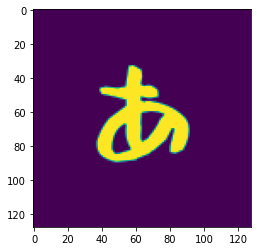

In [30]:
plt.imshow(np_img)

In [36]:
non_zeros_indices = np_img.nonzero()
type(non_zeros_indices)

tuple

In [37]:
len(non_zeros_indices)

2

In [38]:
len(non_zeros_indices[0])

1640

In [39]:
len(non_zeros_indices[1])

1640

In [40]:
non_zeros_indices

(array([33, 33, 33, ..., 89, 89, 89]), array([56, 57, 58, ..., 54, 55, 56]))

In [47]:
zero_ys, zero_xs = np_img.nonzero()[:2]  # `[:2]` just to be safe

min_x, max_x = min(zero_xs), max(zero_xs)
min_y, max_y = min(zero_ys), max(zero_ys)

# the character dimensions is caculated based on the nonzero pixels
character_width = max_x - min_x
character_height = max_y - min_y

min_x, max_x, min_y, max_y, character_width, character_height

(37, 91, 33, 89, 54, 56)

In [45]:
rgb_canvas = np.stack((np_img,)*3, axis=-1)
rgb_canvas.shape

(128, 128, 3)

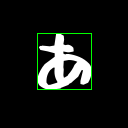

In [60]:
pil_image = Image.fromarray(rgb_canvas)
draw_obj = ImageDraw.Draw(pil_image)

draw_obj.rectangle(
    xy=[(min_x, min_y), (max_x, max_y)],
    outline=(0,255,0),
    width=1,
)

pil_image

In [49]:
pil_image.save('sample_a_with_bounding_box.png', format='PNG')

In [55]:
canvas_size - image_size

64

32 29


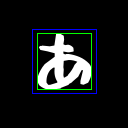

In [62]:
image_offset_top = min_y - int((image_size - character_height)/2)
image_offset_left = min_x - int((image_size - character_width)/2)

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(0,0,255),
    width=1,
)

pil_image

In [63]:
pil_image.save('sample_a_with_bounding_boxes_for_exporting_image.png', 'PNG')

48.0 45.0


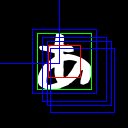

In [59]:
# experiment with image size smaller than font size
image_size = 32
image_offset_top = min_y - (image_size - character_height)/2
image_offset_left = min_x - (image_size - character_width)/2

print(image_offset_left, image_offset_top)

draw_obj.rectangle(
    xy=[(image_offset_left, image_offset_top), (image_offset_left+image_size, image_offset_top+image_size)],
    outline=(255,0,0),
    width=1,
)

pil_image